In [58]:
import nnabla as nn

import nnabla.functions as F
import nnabla.parametric_functions as PF
import nnabla.solvers as S
from nnabla.monitor import tile_images

import numpy as np
import matplotlib.pyplot as plt
import tiny_digits

from sklearn.metrics import classification_report
%matplotlib inline

np.random.seed(0)
imshow_opt = dict(cmap='gray', interpolation='nearest')

Num images: 1797
Image shape: (8, 8)
Labels: [0 1 2 3 4 5 6 7 8 9]


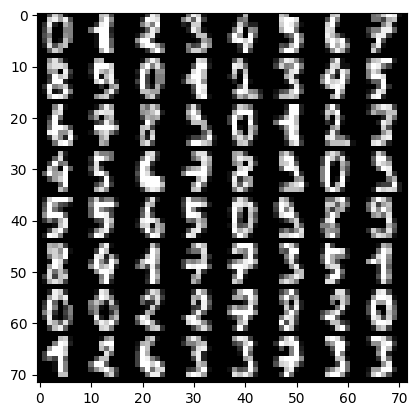

In [59]:
digits = tiny_digits.load_digits(n_class=10)
tiny_digits.plot_stats(digits)

In [60]:
data = tiny_digits.data_iterator_tiny_digits(digits, batch_size=64, shuffle=True)

2023-02-17 06:36:45,678 [nnabla][INFO]: DataSource with shuffle(True)
2023-02-17 06:36:45,683 [nnabla][INFO]: Using DataIterator


labels: [[5 9 7 4 5 7 0 8]
 [1 6 1 7 4 5 8 8]
 [3 3 1 7 1 6 7 9]
 [7 1 3 6 3 6 6 3]
 [7 8 0 1 5 5 4 6]
 [0 5 5 0 8 9 7 8]
 [3 9 8 5 9 7 4 6]
 [8 2 7 6 7 2 3 6]]
Label shape: (64, 1)


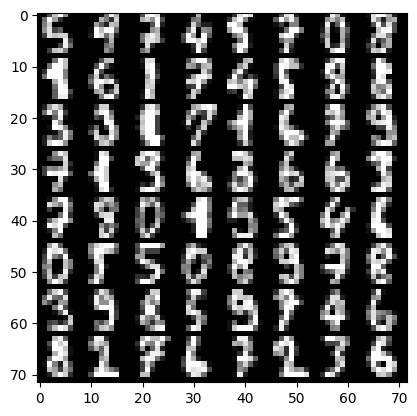

In [61]:
img, label = data.next()
plt.imshow(tile_images(img), **imshow_opt)
print("labels: {}".format(label.reshape(8, 8)))
print("Label shape: {}".format(label.shape))

In [62]:
nn.clear_parameters()

In [63]:
def cnn(x):
    with nn.parameter_scope("cnn"):  # Parameter scope can be nested
        with nn.parameter_scope("conv1"):
            c1 = F.tanh(PF.batch_normalization(
                PF.convolution(x, 4, (3, 3), pad=(1, 1), stride=(2, 2))))
        with nn.parameter_scope("conv2"):
            c2 = F.tanh(PF.batch_normalization(
                PF.convolution(c1, 8, (3, 3), pad=(1, 1))))
            c2 = F.average_pooling(c2, (2, 2))
        with nn.parameter_scope("fc3"):
            fc3 = F.tanh(PF.affine(c2, 32))
        with nn.parameter_scope("classifier"):
            y = PF.affine(fc3, 10)
    return y, [c1, c2, fc3]

In [64]:
x = nn.Variable(img.shape)
t = nn.Variable(label.shape)
x.d, t.d = data.next()
y, hs = cnn(x)

In [65]:

loss = F.mean(F.softmax_cross_entropy(y, t))

def training(steps, learning_rate):
    solver = S.Sgd(learning_rate)
    solver.set_parameters(nn.get_parameters())  # Set parameter variables to be updated.
    for i in range(steps):
        x.d, t.d = data.next()
        loss.forward()
        solver.zero_grad()  # Initialize gradients of all parameters to zero.
        loss.backward()
        solver.weight_decay(1e-5)  # Applying weight decay as an regularization
        solver.update()
        if i % 100 == 0:  # Print for each 10 iterations
            print(i, loss.d)
# Training
training(1000, 1e-1)

0 2.2702155
100 0.70092547
200 0.3950212
300 0.2203522
400 0.26839653
500 0.12993255
600 0.14730515
700 0.12109468
800 0.12710978
900 0.07683214


prediction:
[[7 5 9 0 1 2 3 2]
 [1 1 6 9 4 8 1 8]
 [0 4 5 8 2 4 0 9]
 [6 1 3 3 5 7 0 3]
 [8 4 2 0 9 7 7 4]
 [2 1 4 1 7 3 2 5]
 [8 1 2 7 5 9 8 2]
 [9 4 2 2 8 3 3 7]]


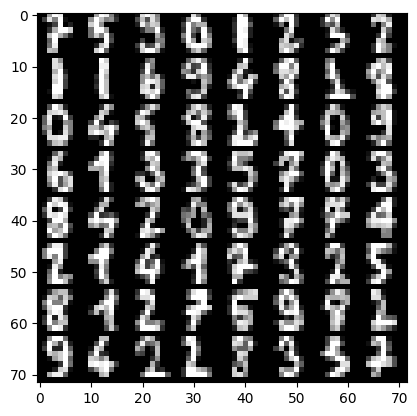

In [66]:
x.d, t.d = data.next()  # Here we predict images from training set although it's useless.
y.forward()  # You can execute a sub graph.
plt.imshow(tile_images(x.d), **imshow_opt)
print("prediction:")
print(y.d.argmax(axis=1).reshape(8, 8))  # Taking a class index based on prediction score.

In [71]:
predicts = np.argmax(y.d, axis=1)

[7 5 9 0 1 2 3 2 1 1 6 9 4 8 1 8 0 4 5 8 2 4 0 9 6 1 3 3 5 7 0 3 8 4 2 0 9
 7 7 4 2 1 4 1 7 3 2 5 8 1 2 7 5 9 8 2 9 4 2 2 8 3 3 7]


In [72]:
print(classification_report(np.reshape(t.d, (-1,)), predicts))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00         5
           1       1.00      1.00      1.00         8
           2       1.00      1.00      1.00        10
           3       1.00      1.00      1.00         7
           4       1.00      1.00      1.00         7
           5       1.00      1.00      1.00         5
           6       1.00      1.00      1.00         2
           7       1.00      1.00      1.00         7
           8       1.00      1.00      1.00         7
           9       1.00      1.00      1.00         6

    accuracy                           1.00        64
   macro avg       1.00      1.00      1.00        64
weighted avg       1.00      1.00      1.00        64

